## PBMC atlas

https://www.nature.com/articles/s41587-023-01881-x#data-availability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
import time
from pathlib import Path
proj_name = "pbmc_atac"
file_name = proj_name
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [4]:
adata = sc.read_h5ad(data_dir / "adata_fixedcells_consensus_processed_Jun07-1959.h5ad")
adata.shape

(169227, 198421)

In [7]:
data_dir

PosixPath('../data/pbmc_atac')

In [8]:
# Load genotype txt file
import pandas as pd
genotype_res = pd.read_csv(data_dir / "genotype_concordance_unified.fixedcells_2_cistopic.txt", sep="\t")
# extract the technology, remove anything after 'FIXEDCELLS'
genotype_res['technology'] = genotype_res.index.str.replace(r'FIXEDCELLS.*', 'FIXEDCELLS', regex=True)
genotype_res['cell_name'] = genotype_res['BARCODE'] + "___" + genotype_res['technology']
# Check overlap between adata and genotype_res
overlap = adata.obs_names.intersection(genotype_res['cell_name'])
print(f"Number of overlapping cells: {len(overlap)}")

Number of overlapping cells: 107176


In [9]:
# Assign called sample to adata.obs
import numpy as np
adata.obs['called_sample'] = np.nan
adata.obs.loc[overlap, 'called_sample'] = genotype_res.set_index('cell_name').loc[overlap, 'sample'].values
adata.obs['called_sample'].value_counts()

called_sample
sampleA    54256
sampleB    52920
Name: count, dtype: int64

In [59]:
# FInd highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat_v3', subset=False)
# PCA and UMAP
n_latent = 50
sc.pp.pca(adata, n_comps=n_latent, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(adata, min_dist=0.1, n_components=2)

In [10]:
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed_HVG.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed_HVG.h5ad'}")

✅ Preprocessed data saved to ../data/pbmc_atac/pbmc_atac_preprocessed_HVG.h5ad


### Create jobs

In [22]:
import subprocess, json
py_methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'cellpath'
batch_key = 'dataset'
state_key = 'None'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed_HVG.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--mem", "32G",  # Adjust memory as needed
    "--conda_env", conda_env,
    "--runtime", "3:00:00",
    "--mode", "wynton"
])


✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_scvi.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_scvi.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_harmony.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_harmony.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_scanorama.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_scanorama.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_liger.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_liger.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_unintegrated.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_unintegrated.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_concord_hcl.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_concord_hcl.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_concord_knn.py
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_concord_knn.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_contrastive.py
✅ Generat

CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'pbmc_atac', '--adata_filename', 'pbmc_atac_preprocessed_HVG.h5ad', '--methods', 'scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive', '--batch_key', 'dataset', '--state_key', 'None', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--mem', '32G', '--conda_env', 'cellpath', '--runtime', '3:00:00', '--mode', 'wynton'], returncode=0)

In [18]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_pbmc_atac/submit_all_pbmc_atac.sh” to queue every job.


In [13]:
ccd.ul.anndata_to_viscello(adata,
                        output_dir=data_dir / f"viscello_{proj_name}",
                        project_name=proj_name,
                        organism='hsa')

VisCello project created at ../data/pbmc_atac/viscello_pbmc_atac


In [17]:
# Generate script for Seurat
import subprocess
r_methods = ["seurat_cca", "seurat_rpca"]
output_dir = '../jobs'
device = 'auto'
subprocess.run([
    "python", "./generate_seurat_script.py",
    "--proj_name", proj_name,
    "--eset_dir", '../'+ str(data_dir / f"viscello_{proj_name}"),   # <- folder w/ eset.rds
    "--methods", *r_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--mem", "200G",  # Adjust memory as needed
    "--runtime", "72:00:00",
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env
])

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_seurat_cca.R
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_seurat_cca.sh

✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_seurat_rpca.R
✅ Generated: benchmark_pbmc_atac/benchmark_pbmc_atac_seurat_rpca.sh



CompletedProcess(args=['python', './generate_seurat_script.py', '--proj_name', 'pbmc_atac', '--eset_dir', '../../data/pbmc_atac/viscello_pbmc_atac', '--methods', 'seurat_cca', 'seurat_rpca', '--batch_key', 'dataset', '--state_key', 'None', '--latent_dim', '50', '--mem', '200G', '--runtime', '72:00:00', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'cellpath'], returncode=0)

In [18]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_pbmc_atac/submit_all_pbmc_atac.sh” to queue every job.


In [81]:
# save adata
adata.write_h5ad(data_dir / f"adata_fixedcells_consensus_processed_{file_suffix}.h5ad")
print(f"Saved adata to {data_dir / f'adata_fixedcells_consensus_processed_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_fixedcells_consensus_processed_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_fixedcells_consensus_processed_{proj_name}_{file_suffix}'}")


Saved adata to ../data/human_pbmc_atac_benchmark/adata_fixedcells_consensus_processed_Jun11-1522.h5ad
Concord - INFO - Normalized expression data (adata.layers['X_log1p']) not found. Renormalize and log transforming.
VisCello project created at ../data/human_pbmc_atac_benchmark/cello_fixedcells_consensus_processed_pbmc_atac_dev_Jun11-1522
Saved viscello to ../data/human_pbmc_atac_benchmark/cello_fixedcells_consensus_processed_pbmc_atac_dev_Jun11-1522


### Compute gene activity matrix

In [17]:
import pandas as pd
import numpy as np
import pybedtools
from anndata import AnnData
from scipy.sparse import csr_matrix, find
import re

# Assume 'adata' is your input scATAC AnnData object (cells x peaks)
# and adata.layers['counts'] contains the raw counts. If using adata.X, replace as needed.
# adata: AnnData object with shape (n_cells, n_peaks)

# Step 1: Create a BEDTool object from peak annotations
print("Step 1: Parsing peaks...")
peak_df = adata.var_names.to_series().str.extract(r'(chr[\w]+):(\d+)-(\d+)')
peak_df.columns = ['chrom', 'start', 'end']
peak_df['start'] = peak_df['start'].astype(int)
peak_df['end'] = peak_df['end'].astype(int)
peak_df['peak_id'] = adata.var_names
peak_bed = pybedtools.BedTool.from_dataframe(peak_df)

# Step 2: Load gene annotations and define gene activity regions
print("Step 2: Processing gene annotations...")
gtf_path = "../resources/refdata-gex-GRCh38-2024-A/genes/genes.gtf"
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    comment="#",
    header=None,
    names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attributes"]
)

# Filter for gene features and parse attributes
genes_df = gtf[gtf["feature"] == "gene"].copy()

def parse_attributes(attr_str):
    attrs = dict(re.findall(r'(\S+) "(.*?)"', attr_str))
    # Use gene_name as the primary identifier, falling back to gene_id if name is absent
    return attrs.get("gene_name", attrs.get("gene_id"))

genes_df["gene_name"] = genes_df["attributes"].apply(parse_attributes)
genes_df = genes_df.dropna(subset=["gene_name"])

# Define gene activity region (gene body + 2kb upstream of TSS)
def make_gene_activity_region(row, upstream=2000):
    # For '+' strand, TSS is at the start
    if row["strand"] == "+":
        promoter_start = max(0, row["start"] - upstream)
        promoter_end = row["start"]
        # The region includes the promoter and the gene body
        return pd.Series([row["chrom"], promoter_start, row["end"], row["gene_name"]])
    # For '-' strand, TSS is at the end
    else:
        promoter_start = row["end"]
        promoter_end = row["end"] + upstream
        # The region includes the gene body and the promoter
        return pd.Series([row["chrom"], row["start"], promoter_end, row["gene_name"]])

gene_regions_df = genes_df.apply(make_gene_activity_region, axis=1)
gene_regions_df.columns = ["chrom", "start", "end", "gene_name"]
gene_regions_bed = pybedtools.BedTool.from_dataframe(gene_regions_df)



Step 1: Parsing peaks...
Step 2: Processing gene annotations...


In [20]:
# Step 3: Find overlaps between peaks and gene activity regions
print("Step 3: Intersecting peaks and genes...")
# Use wa=True, wb=True to get both peak and gene info
# Corrected column names for the output DataFrame
overlap_df = peak_bed.intersect(gene_regions_bed, wa=True, wb=True).to_dataframe(
    names=['peak_chrom', 'peak_start', 'peak_end', 'peak_id',
           'gene_chrom', 'gene_start', 'gene_end', 'gene_name']
)

overlap_df

Step 3: Intersecting peaks and genes...


***** WARNING: File /var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/pybedtools.m15ua464.tmp has inconsistent naming convention for record:
GL000009.2	56140	60376	ENSG00000278704

***** WARNING: File /var/folders/wl/5x49grmn56v77c01bw965mj00000gn/T/pybedtools.m15ua464.tmp has inconsistent naming convention for record:
GL000009.2	56140	60376	ENSG00000278704



,peak_chrom,peak_start,peak_end,peak_id,gene_chrom,gene_start,gene_end,gene_name
0,chr19,44722219,44722719,chr19:44722219-44722719,chr19,44631573,44727217,CEACAM16-AS1
1,chr9,129865026,129865526,chr9:129865026-129865526,chr9,129832698,129881828,USP20
2,chr11,102317693,102318193,chr11:102317693-102318193,chr11,102316173,102330586,ENSG00000288528
3,chr11,102317693,102318193,chr11:102317693-102318193,chr11,102315484,102339403,BIRC3
4,chr13,113112853,113113353,chr13:113112853-113113353,chr13,113103788,113120685,F7
...,...,...,...,...,...,...,...,...
196552,chr22,20266642,20267142,chr22:20266642-20267142,chr22,20241415,20285246,RTN4R
196553,chr9,37034670,37035170,chr9:37034670-37035170,chr9,36833269,37036268,PAX5
196554,chr3,46929956,46930456,chr3:46929956-46930456,chr3,46921726,46984010,CCDC12
196555,chr14,68513770,68514270,chr14:68513770-68514270,chr14,67817779,68730218,RAD51B


In [21]:
# Step 4: Create a binary peak-to-gene mapping matrix (Efficient Method)
print("Step 4: Building peak-to-gene mapping matrix...")
# Create categorical types for faster mapping
overlap_df['peak_id'] = overlap_df['peak_id'].astype('category')
overlap_df['gene_name'] = overlap_df['gene_name'].astype('category')

# Get the integer indices for peaks and genes
peak_indices = overlap_df['peak_id'].cat.codes.values
gene_indices = overlap_df['gene_name'].cat.codes.values

# Get the dimensions for the mapping matrix
n_peaks = len(adata.var_names)
n_genes = len(overlap_df['gene_name'].cat.categories)

# Create the sparse mapping matrix (peaks x genes)
# A value of 1 at (i, j) means peak i maps to gene j
peak_to_gene_matrix = csr_matrix((np.ones_like(peak_indices), (peak_indices, gene_indices)),
                                 shape=(n_peaks, n_genes))
print(f"Peak-to-gene mapping matrix shape: {peak_to_gene_matrix.shape}")

Step 4: Building peak-to-gene mapping matrix...
Peak-to-gene mapping matrix shape: (198421, 26221)


In [48]:
# Step 5: Calculate gene activities via matrix multiplication
print("Step 5: Calculating gene activities...")
# This is the core calculation: (cells x peaks) @ (peaks x genes) -> (cells x genes)
# Ensure you are using the correct count matrix (e.g., adata.X or adata.layers['counts'])
X_activity = adata.layers['counts'] @ peak_to_gene_matrix

Step 5: Calculating gene activities...


In [49]:
X_activity[:20,:20].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [50]:
# Step 6: Construct the final gene activity AnnData object
print("Step 6: Creating final AnnData object...")
gene_names = overlap_df['gene_name'].cat.categories.tolist()
adata_activity = AnnData(
    X=X_activity,
    obs=adata.obs.copy(),
    var=pd.DataFrame(index=gene_names)
)

print("\nGene activity AnnData created successfully!")
print(f"Shape: {adata_activity.shape[0]} cells × {adata_activity.shape[1]} genes")


Step 6: Creating final AnnData object...

Gene activity AnnData created successfully!
Shape: 169227 cells × 26221 genes


In [51]:
adata_activity.X[:20,:20].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [52]:
# Copy adata.obsm to the new AnnData object
adata_activity.layers['counts'] = adata_activity.X.copy()  # Store the original counts in a layer
adata_activity.obsm = adata.obsm.copy()
sc.pp.normalize_total(adata_activity, target_sum=1e4)
# Log transform the gene activity matrix
sc.pp.log1p(adata_activity)

In [54]:
# save adata_activity
import concord as ccd
adata_activity.write_h5ad(data_dir / f"adata_activity_fixedcells_consensus_processed_{file_suffix}.h5ad")
print(f"Saved adata to {data_dir / f'adata_activity_fixedcells_consensus_processed_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(adata_activity, data_dir / f"cello_activity_fixedcells_consensus_processed_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_activity_fixedcells_consensus_processed_{proj_name}_{file_suffix}'}")

Saved adata to ../data/human_pbmc_atac_benchmark/adata_activity_fixedcells_consensus_processed_Jun08-1850.h5ad
Concord - INFO - Normalized expression data (adata.layers['X_log1p']) not found. Renormalize and log transforming.
VisCello project created at ../data/human_pbmc_atac_benchmark/cello_activity_fixedcells_consensus_processed_pbmc_atac_dev_Jun08-1850
Saved viscello to ../data/human_pbmc_atac_benchmark/cello_activity_fixedcells_consensus_processed_pbmc_atac_dev_Jun08-1850


<Axes: >

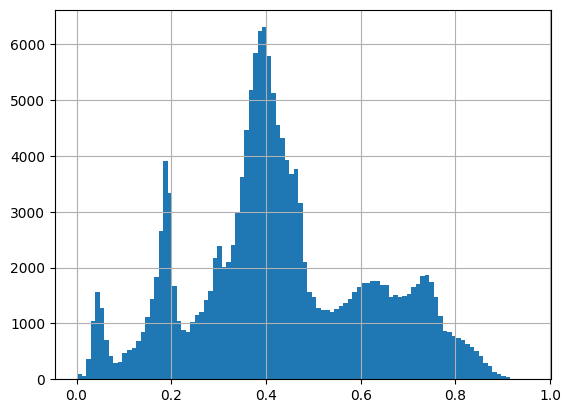

In [60]:
adata.obs['Dupl_rate'].hist(bins=100)